In [1]:
from __future__ import division, print_function

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import numpy.ma as ma
from geopy.distance import vincenty
import matplotlib.colors as colors
import warnings
import math
import scipy.io as sio

import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D

from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
import warnings

# from salishsea_tools import (
#     nc_tools,
#     viz_tools,
# )

%matplotlib inline

In [2]:
# s_bathy = sio.loadmat('/ocean/jthibaul/research/data/SANDWELL_TOPOG_16.1/SS_BATHY.mat', 
#       conda inpip in             struct_as_record=False, squeeze_me=True)
# s_vlon = sio.loadmat('/ocean/jthibaul/research/data/SANDWELL_TOPOG_16.1/SS_vLON.mat', 
#                        struct_as_record=False, squeeze_me=True)
# s_vlat = sio.loadmat('/ocean/jthibaul/research/data/SANDWELL_TOPOG_16.1/SS_vLAT.mat', 
#                        struct_as_record=False, squeeze_me=True)
s_bathy = sio.loadmat('/home/jacquielee/data/SS_BATHY.mat', 
                       struct_as_record=False, squeeze_me=True)
s_vlon = sio.loadmat('/home/jacquielee/data/SS_vLON.mat', 
                       struct_as_record=False, squeeze_me=True)
s_vlat = sio.loadmat('/home/jacquielee/data/SS_vLAT.mat', 
                       struct_as_record=False, squeeze_me=True)

bathy = s_bathy['image_data'][:,3500:15000]
lon = s_vlon['vlon'][3500:15000]
lat = s_vlat['vlat']

In [3]:
bathy0 = np.ma.masked_where(bathy[:,:] > 0.0, bathy)

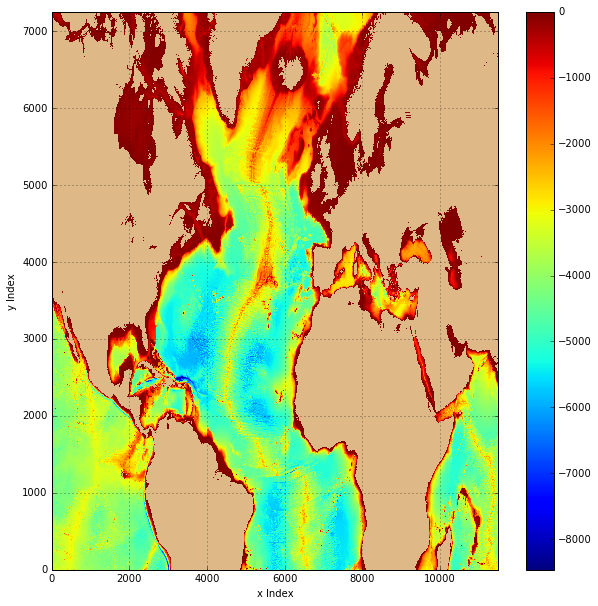

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cmap = plt.get_cmap('jet')
cmap.set_bad('burlywood')
x_lon, y_lat = np.meshgrid(lon, lat)
mesh = ax.pcolormesh(bathy0,cmap=cmap)
cbar = fig.colorbar(mesh,ax=ax)
plt.axis((0, bathy0.shape[1], 0, bathy0.shape[0]))
ax.grid()

ax.set_xlabel('x Index')
ax.set_ylabel('y Index')

In [4]:
# Create algorithm to calculate kappa
import spectrum
from scipy import signal
def kappa(bathy, x, y, length, direction):
    #bathy is 2D grid 
    #x and y are the coords corresponding to bathy
    #length is the number of grid cells kappa will be calculated over
    #direction is either 'x' or 'y' and is a string
    w_num = np.zeros_like(bathy,dtype=float)
    if direction == 'x':
#        r = len(bathy[0,:])-1 % length
        for i in np.arange(0, len(y[:])):
            for j in np.arange(0,len(x),length):

                if j+length <= len(x):
                    end = j+length
                elif j+1 == len(x):
                    #print('if j is the last index in x')
                    w_num[i,j] = w_num[i,j-length]
                    break
                elif j+2 == len(x):
                    #print('if j is the second to last index in y')
                    w_num[i,j:j+1] = w_num[i,j-length]
                    break
                elif j+length > len(x):
                    #print('if j+length longer than x-array')
                    end = len(x)-1
                
                data = data_grid(bathy,i,length,direction,j, end)
                #print(data)
                resid, distance = residuals2(data, i,x,y,direction,j, end)
                #print(resid)
                w_num[i,j:j+length] = pds(resid,bathy,i,direction,distance,j, end)
                # print(w_num)
    if direction == 'y':
        for i in np.arange(0, len(x[:])):
            for j in np.arange(0,len(y),length):
                #print(i,j)
                if j+length <= len(y):
                    end = j+length
                elif j+1 == len(y):
                    #print('if j is the last index in y')
                    w_num[j,i] = w_num[j-length,i]
                    break
                elif j+2 == len(y):
                    #print('if j is the second to last index in y')
                    w_num[j:j+1,i] = w_num[j-length,i]
                    break
                elif j+length > len(y):
                    #print('if j+length longer than y-array')
                    end = len(y)-1
                
                data = data_grid(bathy,i,length,direction,j, end)
                #print(data)
                resid, distance = residuals2(data, i,x,y,direction,j, end)
                #print(resid)
                w_num[j:j+length,i] = pds(resid,bathy,i,direction,distance,j, end)
                #print(w_num)
    
    return w_num

def residuals2(data,i, x,y,direction, start, end):
    #in this function, the coordinates only of the direction
    # (i.e. either x or y) of choice is needed.
    r2 = np.zeros_like(data)
    grid = np.arange(start, end) 

    if direction == 'x':
        distance = distx(y[i],x[start:end])
    elif direction == 'y':
        distance = disty(y[start:end],x[i])
       
            
    fit = np.polyfit(distance[:],data[:],1,full= True)
    for coord in np.arange(0,len(grid)):
        r2[coord] = (data[coord] - (fit[0][0]*distance[coord] + fit[0][1]))**2

    return r2, distance

def distx(lat, lon):
    start = ([lat,lon[0]])
    dist = np.zeros(len(lon))
    for d in np.arange(1,len(lon)):
        end = (lat,lon[d])
        dist[d] = vincenty(start,end).meters
    return dist

def disty(lat, lon):
    start = (lat[0],lon)
    dist = np.zeros(len(lat))
    for d in np.arange(1,len(lat)):
        end = (lat[d],lon)
        dist[d] = vincenty(start,end).meters
    return dist

def data_grid(bathy, i ,length, direction, start, end):
    #creats a data_grid on which to fit polynomial
    grid = np.arange(start, end)
    
#     if len(grid) != length:
#         warnings.warn("data_grid does not equal length!",SyntaxWarning)
    
    if direction == 'x':
        d = np.zeros_like(bathy[i,start:end])
        for coord in np.arange(0,len(grid)):
            d[coord] = bathy[i,grid[coord]]
    elif direction == 'y':
        d = np.zeros_like(bathy[start:end,i])
        for coord in np.arange(0,len(grid)):
            d[coord] = bathy[grid[coord],i]
    return d
    
def pds(r2,bathy, i, direction,distance, start, end):
    #computes the power density spectra of the data_grid
    #find the power spectral density of the data and 
    #take the wavenumber with the largest magnitude
    fs = 2*math.pi/distance[1]
    f, Pxx_den = signal.periodogram(r2, fs=fs,return_onesided=True,scaling='density')
    ind = Pxx_den.argmax()
    w = f[ind]
    #print(w)
#     N_mH = len(r2)
#     T_mH = N_mH/distance
#     x= (np.arange(-N_mH/2,N_mH/2))* 2 * math.pi / distance
#     print(w)
    return w 

In [5]:
# wave15x = kappa(bathy0[:,:],lon[:],lat[:],15,'x')
# wave15y = kappa(bathy0[:,:],lon[:],lat[:],15,'y')

In [6]:
# wave20x = kappa(bathy0[:,:], lon[:],lat[:], 20, 'x')
# wave20y = kappa(bathy0[:,:], lon[:],lat[:], 20, 'y')
wave25x = kappa(bathy0[:,:], lon[:],lat[:], 25, 'x')
wave25y = kappa(bathy0[:,:], lon[:],lat[:], 25, 'y')
wave25x.dump('/mnt/storage0/jacquielee/data/wave25xSS_kappa')
wave25y.dump('/mnt/storage0/jacquielee/data/wave25ySS_kappa')
# wave30x = kappa(bathy0[:,:], lon[:],lat[:], 30, 'x')
# wave30y = kappa(bathy0[:,:], lon[:],lat[:], 30, 'y')
# wave35x = kappa(bathy0[:,:], lon[:],lat[:], 35, 'x')
# wave35y = kappa(bathy0[:,:], lon[:],lat[:], 35, 'y')

In [23]:
# wave15x.dump('/mnt/storage0/jacquielee/data/wave15xSS_kappa')
# wave15y.dump('/mnt/storage0/jacquielee/data/wave15ySS_kappa')
# wave20x.dump('/mnt/storage0/jacquielee/data/wave20xSS_kappa')
# wave20y.dump('/mnt/storage0/jacquielee/data/wave20ySS_kappa')
wave25x.dump('/mnt/storage0/jacquielee/data/wave25xSS_kappa')
wave25y.dump('/mnt/storage0/jacquielee/data/wave25ySS_kappa')
# wave30x.dump('/mnt/storage0/jacquielee/data/wave30xSS_kappa')
# wave30y.dump('/mnt/storage0/jacquielee/data/wave30ySS_kappa')
# wave35x.dump('/mnt/storage0/jacquielee/data/wave35xSS_kappa')
# wave35y.dump('/mnt/storage0/jacquielee/data/wave35ySS_kappa')

In [5]:
wave15x = np.load('/mnt/storage0/jacquielee/data/wave15xSS_kappa')
wave15y = np.load('/mnt/storage0/jacquielee/data/wave15ySS_kappa')
wave20x = np.load('/mnt/storage0/jacquielee/data/wave20xSS_kappa')
wave20y = np.load('/mnt/storage0/jacquielee/data/wave20ySS_kappa')
wave25x = np.load('/mnt/storage0/jacquielee/data/wave25xSS_kappa')
wave25y = np.load('/mnt/storage0/jacquielee/data/wave25ySS_kappa')

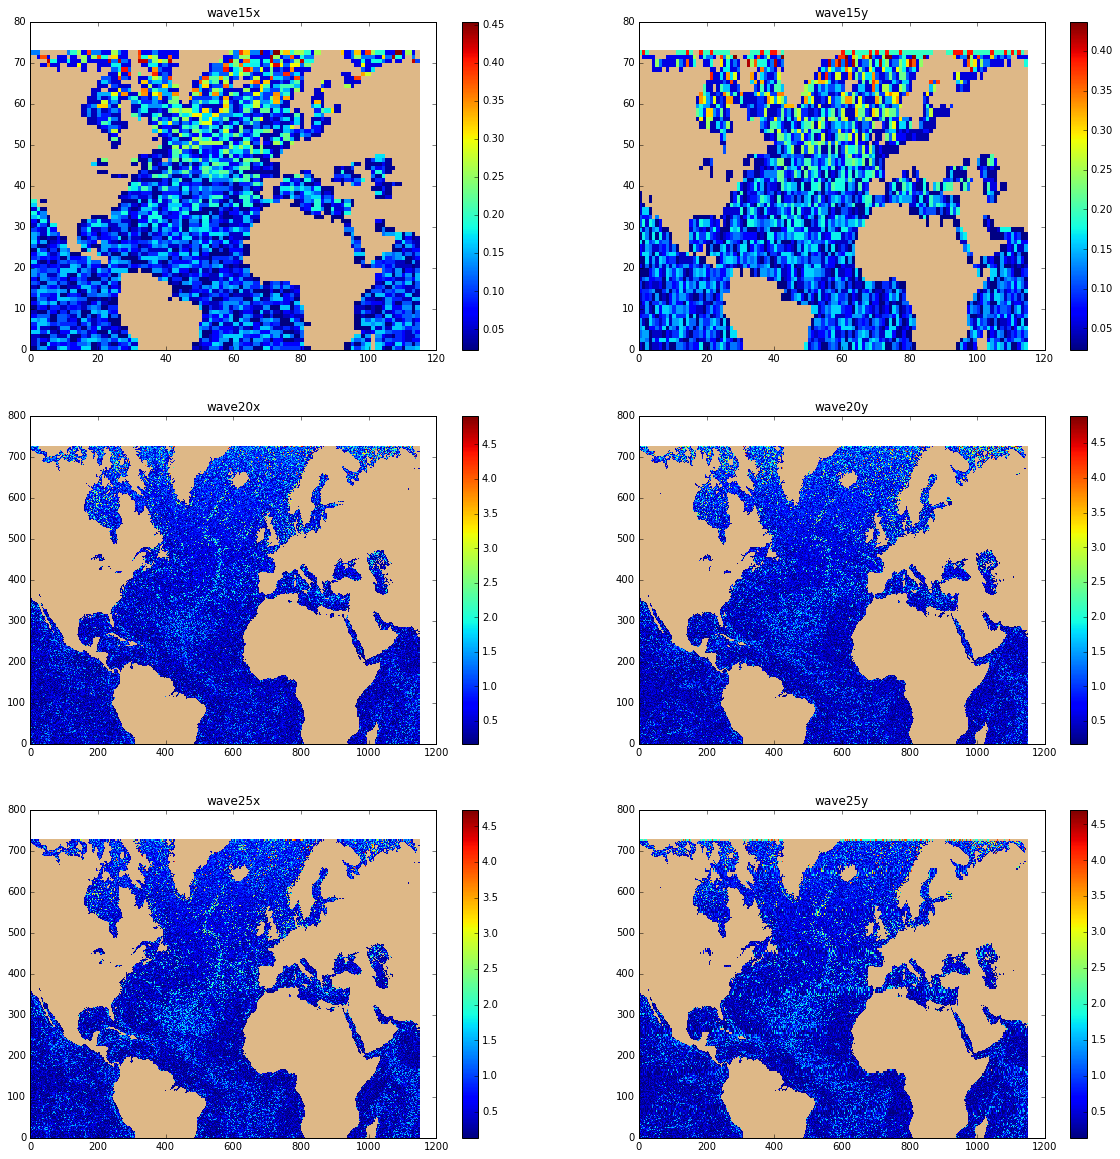

In [9]:
waves = [wave15x,wave15y,wave20x,wave20y,wave25x,wave25y]
waves_title = ['wave15x','wave15y','wave20x','wave20y','wave25x','wave25y']

fig, axes = plt.subplots(3, 2, figsize=(20, 20))

axx = [axes[0][0],axes[0][1],
       axes[1][0],axes[1][1],
       axes[2][0],axes[2][1],]

for w,wt, ax in zip(waves,waves_title,axx):
    w = np.ma.masked_where(w[:,:] == 0.0,w)
    cmap = plt.get_cmap('jet')
    cmap.set_bad('burlywood')
    mesh = ax.pcolormesh(w[::10,::10]*1000,cmap=cmap)
                         #norm=colors.LogNorm(vmin=0.1, vmax=w.max()),cmap=cmap)
    cbar = fig.colorbar(mesh,ax=ax)
    
    ax.set_title(wt)
   # plt.axis((0, w.shape[1], 0, w.shape[0]))

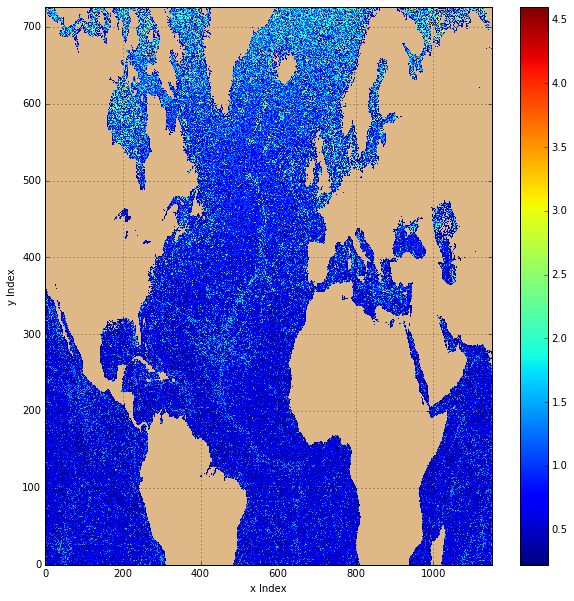

In [49]:
wave15 = np.ma.masked_where(wave15x[::10,::10] == 0.0,wave15x[::10,::10])
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cmap = plt.get_cmap('jet')
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(wave15*1000,cmap=cmap)
cbar = fig.colorbar(mesh,ax=ax)
plt.axis((0, wave15.shape[1], 0, wave15.shape[0]))

# clines = ax.contour(wave15,10,colors='black')
# ax.clabel(clines, fmt='%1.1f')
# # axes.clabel(clines2, fmt='%1.1f')
# cbar1 = plt.colorbar(clines)
# cbar1.add_lines(clines) 
ax.grid()

ax.set_xlabel('x Index')
ax.set_ylabel('y Index')

In [43]:
start = (lat[0],lon[900])
end = (lat[1],lon[900])
dist = vincenty(start,end).meters
    
print(dist)

1722.75608668
